In [1]:
from pathlib import Path
import os

PATH = (Path(os.getcwd()) / '..' / '..').resolve()
os.environ['WANDB_CACHE_DIR'] = str(PATH / "wandb/cache")

import wandb
api = wandb.Api()

In [2]:
import stanza.util
import pandas

SWEEP_ID = "i5616y3x"

def process_sweep(s):
    print("Processing sweep", s.id)
    runs = s.runs
    data = []
    # artifacts_dir = PATH / "wandb" / Path("artifacts")
    for i, run in enumerate(runs):
        if i % 300 == 0 or i == len(runs) - 1:
            print(f"Processing run {i+1}/{len(runs)}")
        run_data = dict(run.summary)
        config = dict(run.config)
        run = {'id': run.id, 'name': run.name, 'config':config, 'data':run_data}
        run = stanza.util.flatten_to_dict(run)[0]
        data.append(run)
    return data
runs = process_sweep(api.sweep(f"dpfrommer-projects/stanza-examples/{SWEEP_ID}"))
data = pandas.DataFrame(runs)

Processing sweep i5616y3x
Processing run 1/11
Processing run 11/11


In [3]:
data

,config.batch_size,config.cycle_mult,config.cycles,config.dataset,config.epochs,config.lr_schedule,config.model,config.normalizer,config.optimizer,config.sam_percent,...,data.sharpness/sigma_percentile_75,data.sharpness/sigma_percentile_95,data.sharpness/sigma_trace,data.test/accuracy,data.test/cross_entropy,data.train/accuracy,data.train/cross_entropy,id,name,data._wandb
0,16,2,1,cifar10,50,cosine,SmallResNet18,standard_dev,adam,1,...,0.103605,0.576261,1.129715,0.8931,0.498911,1.0000,0.000865,80trm2ji,distinctive-sweep-11,NaN
1,16,2,1,cifar10,50,cosine,SmallResNet18,standard_dev,adam,1,...,0.024718,0.167184,0.327480,0.8976,0.487542,0.9375,0.066145,ydptezw2,blooming-sweep-10,{'runtime': 1481}
2,16,2,1,cifar10,50,cosine,SmallResNet18,standard_dev,sgd,1,...,8.458640,26.106628,64.888023,0.9082,0.349947,1.0000,0.002252,cl9ov6m6,robust-sweep-9,{'runtime': 905}
3,16,2,1,cifar10,50,cosine,SmallResNet18,standard_dev,sgd,1,...,2.217639,2.906656,10.688719,0.9187,0.247139,1.0000,0.034610,sp38yzu8,toasty-sweep-8,{'runtime': 1342}
4,16,2,1,cifar10,50,cosine,SmallResNet18,standard_dev,sgd,1,...,3.221988,4.831308,17.370033,0.9175,0.241132,0.9375,0.120960,0x5wfacp,cool-sweep-7,{'runtime': 1358}
5,8,2,1,cifar10,50,cosine,SmallResNet18,standard_dev,adam,1,...,0.119196,0.762490,1.466839,0.8904,0.492899,1.0000,0.000638,l83jmrfy,rural-sweep-6,{'runtime': 1872}
6,8,2,1,cifar10,50,cosine,SmallResNet18,standard_dev,adam,1,...,0.130919,0.432261,1.103126,0.8937,0.473052,1.0000,0.000023,0lvcp4q6,woven-sweep-5,{'runtime': 2617}
7,8,2,1,cifar10,50,cosine,SmallResNet18,standard_dev,adam,1,...,0.089942,0.313910,0.725696,0.8955,0.462937,1.0000,0.000005,urhfhrsz,sweet-sweep-4,{'runtime': 2621}
8,8,2,1,cifar10,50,cosine,SmallResNet18,standard_dev,sgd,1,...,13.521786,20.784348,68.930992,0.9119,0.314037,1.0000,0.000349,nrc8aw1l,clear-sweep-3,{'runtime': 1601}
9,8,2,1,cifar10,50,cosine,SmallResNet18,standard_dev,sgd,1,...,5.106325,10.923508,34.055267,0.9240,0.231914,1.0000,0.018688,0p8hpniw,proud-sweep-2,{'runtime': 2379}


In [72]:
import matplotlib.pyplot as plt
plt.ioff()

from IPython.display import display
import numpy as np
import seaborn as sns
sns.set_theme()

def make_plots(data):
    fig, axs = plt.subplots(2, 2, sharey=True)

    xs = ["Batch Size", "Hessian Trace"]
    ys = ["Hessian Trace", "Test Accuracy"]
    for i, x in enumerate(xs):
        axs[-1, i].set_xlabel(x)
    for j, y in enumerate(ys):
        axs[j, 0].set_ylabel(y)

    rhos = data['config.sam_rho'].unique()
    for rho in rhos:
        rho_data = data[data['config.sam_rho'] == rho]
        rho_data = rho_data.sort_values('config.batch_size')
        batch_size = np.array(rho_data['config.batch_size'])
        sharpness = np.array(rho_data['data.sharpness/sigma_trace'])
        accuracy = np.array(rho_data['data.test/accuracy'])
        xs = [batch_size, sharpness]
        ys = [sharpness, accuracy]
        for i, x in enumerate(xs):
            for j, y in enumerate(ys):
                if i == 0 and j == 0:
                    axs[j,i].plot(x,y, label=f"rho={rho}")
                else:
                    axs[j,i].plot(x,y)
    fig.legend()
    return fig

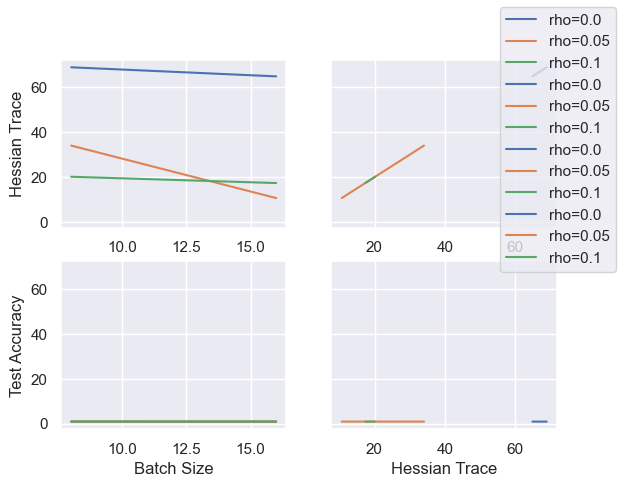

In [73]:
sgd_data = data[data['config.optimizer'] == 'sgd']
make_plots(sgd_data)

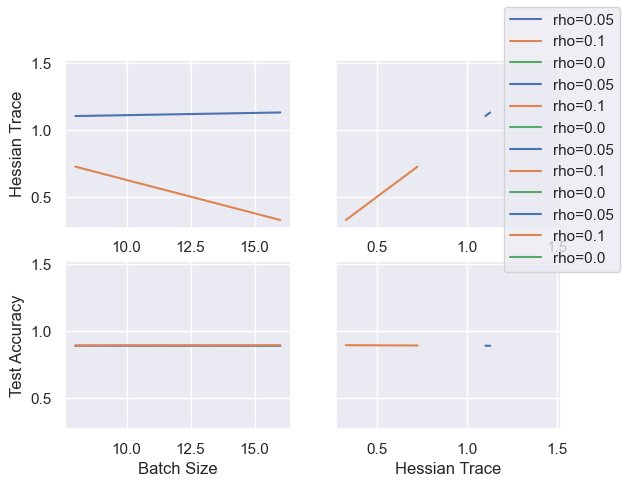

In [74]:
adam_data = data[data['config.optimizer'] == 'adam']
make_plots(adam_data)